In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/water_bodies.zip"
extract_path = "/content/drive/MyDrive/Water_Bodies_Dataset"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted successfully!")
else:
    print("Dataset already extracted.")


Dataset already extracted.


In [17]:
!cp -r /content/drive/MyDrive/Water_Bodies_Dataset /content/


In [18]:
!pip install segmentation-models


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.1 MB/s eta 0:00:00


In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate


In [19]:
IMAGE_DIR = "/content/Water_Bodies_Dataset/Water Bodies Dataset/Images"
MASK_DIR  = "/content/Water_Bodies_Dataset/Water Bodies Dataset/Masks"

IMAGE_SIZE = 256


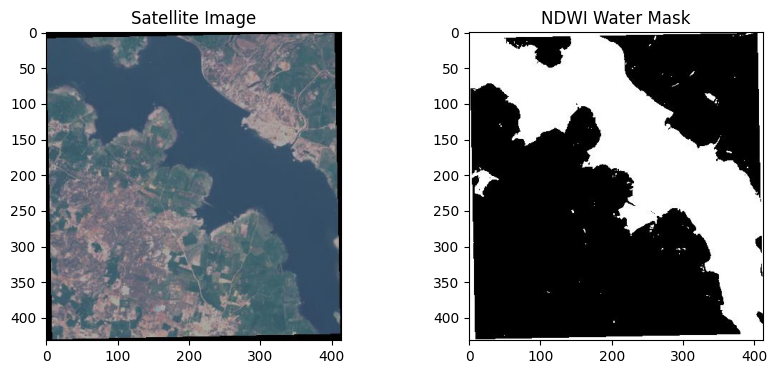

In [20]:
#Read One Sample (Sanity Check)
img_name = os.listdir(IMAGE_DIR)[0]

image = cv2.imread(os.path.join(IMAGE_DIR, img_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(os.path.join(MASK_DIR, img_name), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Satellite Image")

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title("NDWI Water Mask")
plt.show()


In [21]:
#Data Generator (Memory-Efficient) - Custom Data Generator
class DataGenerator(Sequence):
    def __init__(self, images, batch_size=8):
        self.images = images
        self.batch_size = batch_size

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        batch_images = self.images[idx*self.batch_size:(idx+1)*self.batch_size]

        X, y = [], []

        for img_name in batch_images:
            img = cv2.imread(os.path.join(IMAGE_DIR, img_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
            img = img / 255.0

            mask = cv2.imread(os.path.join(MASK_DIR, img_name), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)

            X.append(img)
            y.append(mask)

        return np.array(X), np.array(y)


In [22]:
#Train–Test Split
all_images = os.listdir(IMAGE_DIR)

train_imgs, val_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

train_gen = DataGenerator(train_imgs)
val_gen   = DataGenerator(val_imgs)


In [23]:
#U-Net Model
def build_unet():
    inputs = Input((256,256,3))

    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)

    u1 = UpSampling2D()(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(128, 3, activation='relu', padding='same')(u1)

    u2 = UpSampling2D()(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u2)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)

    return Model(inputs, outputs)


In [24]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

model = build_unet()
model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', MeanIoU(num_classes=2)]
)


In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Callbacks ---
# Stop training if validation loss doesn't improve for 3 epochs
early_stop = EarlyStopping(
    monitor='val_loss',     # monitor validation loss
    patience=3,             # wait 3 epochs before stopping
    restore_best_weights=True  # restore best model
)

# Optional: save the best model automatically
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/MajorProject/unet_water_best.h5',
    monitor='val_loss',
    save_best_only=True
)

# --- Train the model ---
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,           # max epochs, early stopping may stop earlier
    callbacks=[early_stop, checkpoint],
    verbose=1
)




Epoch 1/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6180 - loss: 0.5546 - mean_io_u_1: 0.3775

284/284 ━━━━━━━━━━━━━━━━━━━━ 80s 282ms/step - accuracy: 0.6181 - loss: 0.5544 - mean_io_u_1: 0.3775 - val_accuracy: 0.6787 - val_loss: 0.4623 - val_mean_io_u_1: 0.3789
Epoch 2/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.6750 - loss: 0.4475 - mean_io_u_1: 0.3776

284/284 ━━━━━━━━━━━━━━━━━━━━ 75s 265ms/step - accuracy: 0.6750 - loss: 0.4475 - mean_io_u_1: 0.3776 - val_accuracy: 0.6956 - val_loss: 0.4119 - val_mean_io_u_1: 0.3789
Epoch 3/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7034 - loss: 0.4080 - mean_io_u_1: 0.3762

284/284 ━━━━━━━━━━━━━━━━━━━━ 71s 249ms/step - accuracy: 0.7034 - loss: 0.4080 - mean_io_u_1: 0.3762 - val_accuracy: 0.7131 - val_loss: 0.3833 - val_mean_io_u_1: 0.3789
Epoch 4/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7071 - loss: 0.3871 - mean_io_u_1: 0.3758

284/284 ━━━━━━━━━━━━━━━━━━━━ 71s 248ms/step - accuracy: 0.7071 - loss: 0.3871 - mean_io_u_1: 0.3758 - val_accuracy: 0.7160 - val_loss: 0.3624 - val_mean_io_u_1: 0.3789
Epoch 5/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 245ms/step - accuracy: 0.7134 - loss: 0.3701 - mean_io_u_1: 0.3791 - val_accuracy: 0.6920 - val_loss: 0.4127 - val_mean_io_u_1: 0.3789
Epoch 6/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 245ms/step - accuracy: 0.7174 - loss: 0.3633 - mean_io_u_1: 0.3744 - val_accuracy: 0.7060 - val_loss: 0.3689 - val_mean_io_u_1: 0.3789
Epoch 7/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7272 - loss: 0.3490 - mean_io_u_1: 0.3762

284/284 ━━━━━━━━━━━━━━━━━━━━ 71s 248ms/step - accuracy: 0.7272 - loss: 0.3490 - mean_io_u_1: 0.3762 - val_accuracy: 0.7238 - val_loss: 0.3417 - val_mean_io_u_1: 0.3789
Epoch 8/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 245ms/step - accuracy: 0.7183 - loss: 0.3521 - mean_io_u_1: 0.3776 - val_accuracy: 0.7143 - val_loss: 0.3608 - val_mean_io_u_1: 0.3789
Epoch 9/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7188 - loss: 0.3558 - mean_io_u_1: 0.3726

284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 248ms/step - accuracy: 0.7188 - loss: 0.3558 - mean_io_u_1: 0.3727 - val_accuracy: 0.7251 - val_loss: 0.3353 - val_mean_io_u_1: 0.3789
Epoch 10/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 246ms/step - accuracy: 0.7255 - loss: 0.3385 - mean_io_u_1: 0.3797 - val_accuracy: 0.7215 - val_loss: 0.3436 - val_mean_io_u_1: 0.3796
Epoch 11/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7294 - loss: 0.3246 - mean_io_u_1: 0.3812

284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 248ms/step - accuracy: 0.7293 - loss: 0.3246 - mean_io_u_1: 0.3812 - val_accuracy: 0.7284 - val_loss: 0.3283 - val_mean_io_u_1: 0.3795
Epoch 12/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 245ms/step - accuracy: 0.7291 - loss: 0.3316 - mean_io_u_1: 0.3778 - val_accuracy: 0.7276 - val_loss: 0.3297 - val_mean_io_u_1: 0.3792
Epoch 13/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7233 - loss: 0.3311 - mean_io_u_1: 0.3765

284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 248ms/step - accuracy: 0.7233 - loss: 0.3311 - mean_io_u_1: 0.3765 - val_accuracy: 0.7305 - val_loss: 0.3227 - val_mean_io_u_1: 0.3794
Epoch 14/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 245ms/step - accuracy: 0.7258 - loss: 0.3306 - mean_io_u_1: 0.3789 - val_accuracy: 0.7308 - val_loss: 0.3281 - val_mean_io_u_1: 0.3801
Epoch 15/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7290 - loss: 0.3244 - mean_io_u_1: 0.3825

284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 247ms/step - accuracy: 0.7290 - loss: 0.3244 - mean_io_u_1: 0.3825 - val_accuracy: 0.7318 - val_loss: 0.3192 - val_mean_io_u_1: 0.3808
Epoch 16/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7236 - loss: 0.3339 - mean_io_u_1: 0.3751

284/284 ━━━━━━━━━━━━━━━━━━━━ 75s 265ms/step - accuracy: 0.7236 - loss: 0.3338 - mean_io_u_1: 0.3751 - val_accuracy: 0.7302 - val_loss: 0.3171 - val_mean_io_u_1: 0.3812
Epoch 17/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 245ms/step - accuracy: 0.7287 - loss: 0.3240 - mean_io_u_1: 0.3781 - val_accuracy: 0.7201 - val_loss: 0.3330 - val_mean_io_u_1: 0.3802
Epoch 18/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 245ms/step - accuracy: 0.7323 - loss: 0.3175 - mean_io_u_1: 0.3835 - val_accuracy: 0.7253 - val_loss: 0.3275 - val_mean_io_u_1: 0.3814
Epoch 19/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7339 - loss: 0.3141 - mean_io_u_1: 0.3810

284/284 ━━━━━━━━━━━━━━━━━━━━ 71s 248ms/step - accuracy: 0.7339 - loss: 0.3141 - mean_io_u_1: 0.3810 - val_accuracy: 0.7287 - val_loss: 0.3151 - val_mean_io_u_1: 0.3820
Epoch 20/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7393 - loss: 0.3061 - mean_io_u_1: 0.3829

284/284 ━━━━━━━━━━━━━━━━━━━━ 71s 248ms/step - accuracy: 0.7393 - loss: 0.3061 - mean_io_u_1: 0.3829 - val_accuracy: 0.7344 - val_loss: 0.3112 - val_mean_io_u_1: 0.3820


In [ ]:
model.save('/content/drive/MyDrive/MajorProject/unet_water_model.h5')


In [29]:
#NDWI Comparison (INNOVATION PART)
#Predict & Compare
def predict_image(img_name):
    img = cv2.imread(os.path.join(IMAGE_DIR, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    img_norm = img / 255.0

    pred = model.predict(np.expand_dims(img_norm, axis=0))[0]
    pred_mask = (pred > 0.5).astype(np.uint8)

    gt_mask = cv2.imread(os.path.join(MASK_DIR, img_name), cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.resize(gt_mask, (256,256))
    gt_mask = (gt_mask > 127).astype(np.uint8)

    return img, gt_mask, pred_mask

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


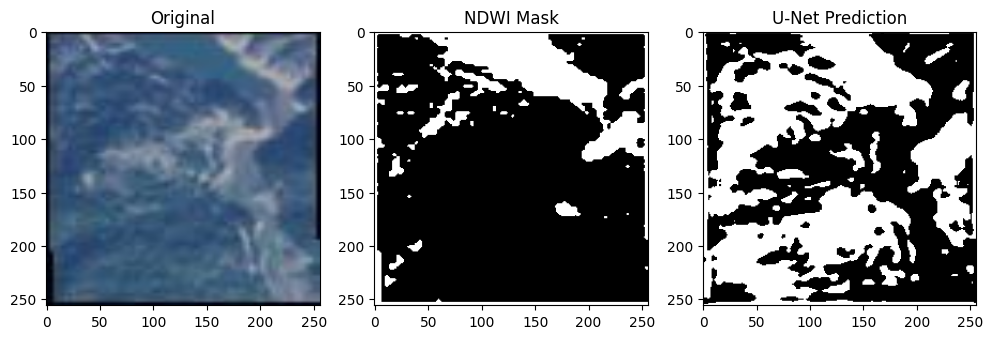

In [30]:
#Visual Comparison
img, ndwi_mask, unet_mask = predict_image(val_imgs[0])

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(ndwi_mask, cmap='gray')
plt.title("NDWI Mask")

plt.subplot(1,3,3)
plt.imshow(unet_mask, cmap='gray')
plt.title("U-Net Prediction")
plt.show()


In [31]:
#Water Area Calculation (REAL ANALYSIS)
def calculate_water_area(mask):
    water_pixels = np.sum(mask)
    area_m2 = water_pixels * 100
    area_km2 = area_m2 / 1e6
    return area_km2

area = calculate_water_area(unet_mask)
print(f"Estimated Water Area: {area:.3f} km²")


Estimated Water Area: 3.346 km²


###same with modifications

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.5874 - loss: 0.9185 - mean_io_u_4: 0.3713

284/284 ━━━━━━━━━━━━━━━━━━━━ 157s 456ms/step - accuracy: 0.5875 - loss: 0.9182 - mean_io_u_4: 0.3713 - val_accuracy: 0.2728 - val_loss: 2.1291 - val_mean_io_u_4: 0.3825
Epoch 2/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6454 - loss: 0.7262 - mean_io_u_4: 0.3754

284/284 ━━━━━━━━━━━━━━━━━━━━ 124s 437ms/step - accuracy: 0.6454 - loss: 0.7262 - mean_io_u_4: 0.3754 - val_accuracy: 0.7140 - val_loss: 0.7512 - val_mean_io_u_4: 0.3825
Epoch 3/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6521 - loss: 0.6926 - mean_io_u_4: 0.3694

284/284 ━━━━━━━━━━━━━━━━━━━━ 142s 436ms/step - accuracy: 0.6521 - loss: 0.6927 - mean_io_u_4: 0.3694 - val_accuracy: 0.7149 - val_loss: 0.7034 - val_mean_io_u_4: 0.3876
Epoch 4/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 122s 429ms/step - accuracy: 0.6584 - loss: 0.6822 - mean_io_u_4: 0.3745 - val_accuracy: 0.7038 - val_loss: 0.7142 - val_mean_io_u_4: 0.3828
Epoch 5/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.6657 - loss: 0.6494 - mean_io_u_4: 0.3751

284/284 ━━━━━━━━━━━━━━━━━━━━ 124s 435ms/step - accuracy: 0.6657 - loss: 0.6494 - mean_io_u_4: 0.3751 - val_accuracy: 0.7195 - val_loss: 0.6755 - val_mean_io_u_4: 0.3882
Epoch 6/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6627 - loss: 0.6442 - mean_io_u_4: 0.3689

284/284 ━━━━━━━━━━━━━━━━━━━━ 124s 436ms/step - accuracy: 0.6627 - loss: 0.6442 - mean_io_u_4: 0.3689 - val_accuracy: 0.7335 - val_loss: 0.6063 - val_mean_io_u_4: 0.3980
Epoch 7/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 122s 428ms/step - accuracy: 0.6629 - loss: 0.6259 - mean_io_u_4: 0.3661 - val_accuracy: 0.7016 - val_loss: 0.7121 - val_mean_io_u_4: 0.3854
Epoch 8/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6592 - loss: 0.6283 - mean_io_u_4: 0.3749

284/284 ━━━━━━━━━━━━━━━━━━━━ 124s 435ms/step - accuracy: 0.6593 - loss: 0.6282 - mean_io_u_4: 0.3749 - val_accuracy: 0.7343 - val_loss: 0.6016 - val_mean_io_u_4: 0.3826
Epoch 9/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 122s 429ms/step - accuracy: 0.6777 - loss: 0.5868 - mean_io_u_4: 0.3725 - val_accuracy: 0.7300 - val_loss: 0.6368 - val_mean_io_u_4: 0.3835
Epoch 10/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 121s 427ms/step - accuracy: 0.6792 - loss: 0.5814 - mean_io_u_4: 0.3779 - val_accuracy: 0.7006 - val_loss: 0.6936 - val_mean_io_u_4: 0.3850
Epoch 11/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6758 - loss: 0.5880 - mean_io_u_4: 0.3775

284/284 ━━━━━━━━━━━━━━━━━━━━ 124s 437ms/step - accuracy: 0.6758 - loss: 0.5880 - mean_io_u_4: 0.3775 - val_accuracy: 0.7352 - val_loss: 0.5869 - val_mean_io_u_4: 0.3827
Epoch 12/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 122s 429ms/step - accuracy: 0.6829 - loss: 0.5590 - mean_io_u_4: 0.3790 - val_accuracy: 0.7344 - val_loss: 0.5893 - val_mean_io_u_4: 0.3850
Epoch 13/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 122s 429ms/step - accuracy: 0.6816 - loss: 0.5615 - mean_io_u_4: 0.3798 - val_accuracy: 0.7325 - val_loss: 0.6402 - val_mean_io_u_4: 0.3830
Epoch 14/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6841 - loss: 0.5514 - mean_io_u_4: 0.3764

284/284 ━━━━━━━━━━━━━━━━━━━━ 144s 436ms/step - accuracy: 0.6841 - loss: 0.5515 - mean_io_u_4: 0.3764 - val_accuracy: 0.7415 - val_loss: 0.5644 - val_mean_io_u_4: 0.3895
Epoch 15/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 122s 430ms/step - accuracy: 0.6872 - loss: 0.5490 - mean_io_u_4: 0.3787 - val_accuracy: 0.7373 - val_loss: 0.5924 - val_mean_io_u_4: 0.3870
Epoch 16/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6836 - loss: 0.5397 - mean_io_u_4: 0.3763

284/284 ━━━━━━━━━━━━━━━━━━━━ 124s 435ms/step - accuracy: 0.6837 - loss: 0.5397 - mean_io_u_4: 0.3763 - val_accuracy: 0.7415 - val_loss: 0.5639 - val_mean_io_u_4: 0.3835
Epoch 17/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 122s 431ms/step - accuracy: 0.6880 - loss: 0.5197 - mean_io_u_4: 0.3742 - val_accuracy: 0.7056 - val_loss: 0.6599 - val_mean_io_u_4: 0.3832
Epoch 18/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 122s 429ms/step - accuracy: 0.6910 - loss: 0.5142 - mean_io_u_4: 0.3761 - val_accuracy: 0.7335 - val_loss: 0.5657 - val_mean_io_u_4: 0.3841
Epoch 19/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6901 - loss: 0.5033 - mean_io_u_4: 0.3772

284/284 ━━━━━━━━━━━━━━━━━━━━ 124s 436ms/step - accuracy: 0.6901 - loss: 0.5034 - mean_io_u_4: 0.3772 - val_accuracy: 0.7478 - val_loss: 0.5366 - val_mean_io_u_4: 0.3872
Epoch 20/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 123s 433ms/step - accuracy: 0.6856 - loss: 0.5080 - mean_io_u_4: 0.3796 - val_accuracy: 0.7459 - val_loss: 0.5592 - val_mean_io_u_4: 0.3897
Epoch 21/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 122s 428ms/step - accuracy: 0.6992 - loss: 0.4962 - mean_io_u_4: 0.3813 - val_accuracy: 0.7193 - val_loss: 0.6124 - val_mean_io_u_4: 0.3868
Epoch 22/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 123s 431ms/step - accuracy: 0.6886 - loss: 0.5035 - mean_io_u_4: 0.3810 - val_accuracy: 0.7416 - val_loss: 0.5520 - val_mean_io_u_4: 0.3940
Epoch 23/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 122s 428ms/step - accuracy: 0.6948 - loss: 0.4906 - mean_io_u_4: 0.3815 - val_accuracy: 0.7243 - val_loss: 0.6232 - val_mean_io_u_4: 0.3857
Epoch 24/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6890 - loss: 0.4846 - mean_io_u_4: 0.3

284/284 ━━━━━━━━━━━━━━━━━━━━ 124s 435ms/step - accuracy: 0.6890 - loss: 0.4847 - mean_io_u_4: 0.3758 - val_accuracy: 0.7536 - val_loss: 0.5198 - val_mean_io_u_4: 0.3934
Epoch 25/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 122s 428ms/step - accuracy: 0.6928 - loss: 0.4961 - mean_io_u_4: 0.3824 - val_accuracy: 0.7391 - val_loss: 0.5884 - val_mean_io_u_4: 0.4060
Epoch 26/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 122s 428ms/step - accuracy: 0.7013 - loss: 0.4753 - mean_io_u_4: 0.3800 - val_accuracy: 0.7498 - val_loss: 0.5367 - val_mean_io_u_4: 0.4264
Epoch 27/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 122s 427ms/step - accuracy: 0.6966 - loss: 0.4642 - mean_io_u_4: 0.3864 - val_accuracy: 0.7440 - val_loss: 0.5754 - val_mean_io_u_4: 0.3979
Epoch 28/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 121s 427ms/step - accuracy: 0.7010 - loss: 0.4558 - mean_io_u_4: 0.3832 - val_accuracy: 0.7466 - val_loss: 0.5375 - val_mean_io_u_4: 0.3873
Epoch 29/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 123s 431ms/step - accuracy: 0.7031 - loss: 0.4592 - mean_io_u_4: 0

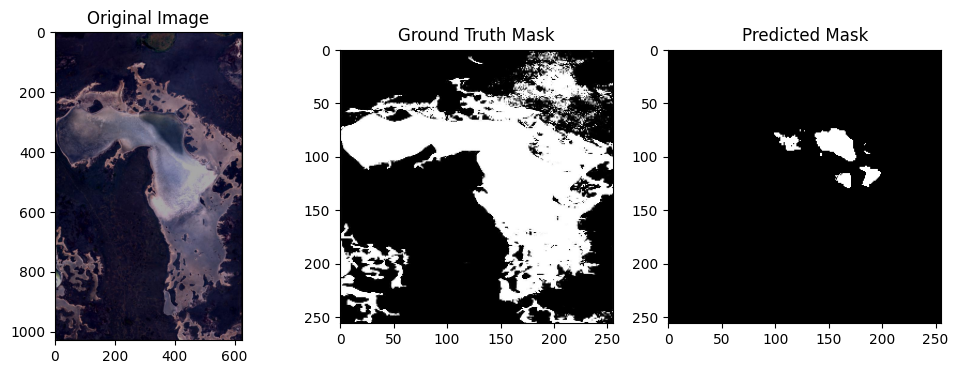

Predicted Water Area: 132200 sq.m
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


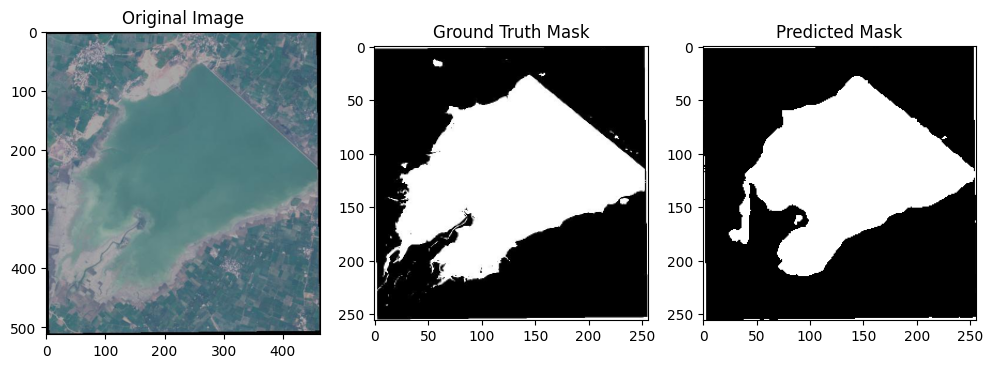

Predicted Water Area: 2281500 sq.m
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


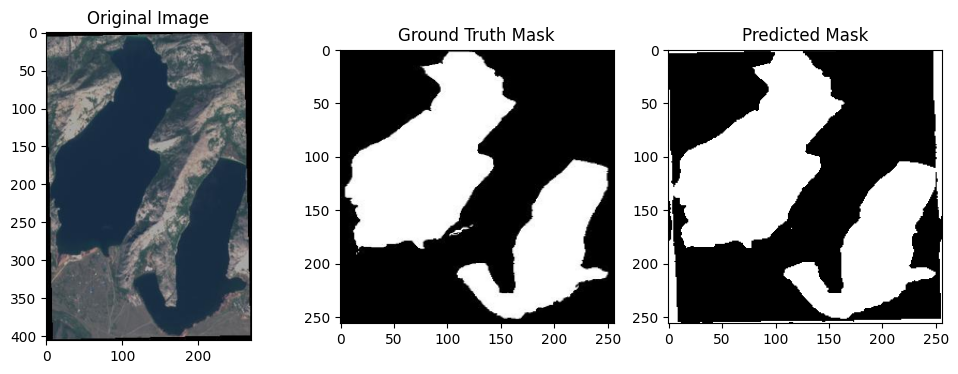

Predicted Water Area: 2857700 sq.m


In [38]:
# ==============================
# 1️⃣ Mount Google Drive
# ==============================
from google.colab import drive
drive.mount('/content/drive')

# ==============================
# 2️⃣ Imports
# ==============================
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ==============================
# 3️⃣ Dataset Paths
# ==============================
IMAGE_DIR = "/content/Water_Bodies_Dataset/Water Bodies Dataset/Images"
MASK_DIR  = "/content/Water_Bodies_Dataset/Water Bodies Dataset/Masks"

IMAGE_SIZE = 256  # Resize images

# ==============================
# 4️⃣ Custom Data Generator with Augmentation
# ==============================
class DataGenerator(Sequence):
    def __init__(self, images, batch_size=8, augment=False):
        self.images = images
        self.batch_size = batch_size
        self.augment = augment
        self.img_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=0.1
        )
        self.mask_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=0.1
        )

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        batch_images = self.images[idx*self.batch_size:(idx+1)*self.batch_size]
        X, y = [], []
        for img_name in batch_images:
            # Read and preprocess image
            img = cv2.imread(os.path.join(IMAGE_DIR, img_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
            img = img / 255.0

            # Read and preprocess mask
            mask = cv2.imread(os.path.join(MASK_DIR, img_name), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)

            X.append(img)
            y.append(mask)

        X = np.array(X)
        y = np.array(y)

        # Apply augmentation
        if self.augment:
            seed = np.random.randint(1e6)
            X = iter(self.img_datagen.flow(X, batch_size=self.batch_size, shuffle=False, seed=seed)).__next__()
            y = iter(self.mask_datagen.flow(y, batch_size=self.batch_size, shuffle=False, seed=seed)).__next__()

        return X, y

# ==============================
# 5️⃣ Train-Test Split
# ==============================
all_images = sorted(os.listdir(IMAGE_DIR))
train_imgs, val_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

train_gen = DataGenerator(train_imgs, batch_size=8, augment=True)
val_gen   = DataGenerator(val_imgs, batch_size=8, augment=False)

# ==============================
# 6️⃣ Improved U-Net Model (with BatchNorm & more filters)
# ==============================
def build_unet():
    inputs = Input((IMAGE_SIZE, IMAGE_SIZE, 3))

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D()(c3)

    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    # Decoder
    u1 = UpSampling2D()(c4)
    u1 = concatenate([u1, c3])
    c5 = Conv2D(256, 3, activation='relu', padding='same')(u1)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(256, 3, activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    u2 = UpSampling2D()(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(128, 3, activation='relu', padding='same')(u2)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(128, 3, activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u3 = UpSampling2D()(c6)
    u3 = concatenate([u3, c1])
    c7 = Conv2D(64, 3, activation='relu', padding='same')(u3)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)
    return Model(inputs, outputs)

# ==============================
# 7️⃣ Dice + BCE Loss
# ==============================
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

# ==============================
# 8️⃣ Compile Model
# ==============================
model = build_unet()
model.compile(
    optimizer=Adam(1e-4),
    loss=bce_dice_loss,
    metrics=['accuracy', MeanIoU(num_classes=2)]
)

# ==============================
# 9️⃣ Callbacks
# ==============================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/MajorProject/unet_water_best.h5',
    monitor='val_loss',
    save_best_only=True
)

# ==============================
#  🔟 Train Model
# ==============================
steps_per_epoch = len(train_imgs) // 8
validation_steps = len(val_imgs) // 8

history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)

# ==============================
#  1️⃣1️⃣ Load Best Model & Evaluate
# ==============================
model = load_model('/content/drive/MyDrive/MajorProject/unet_water_best.h5',
                   compile=False)
model.compile(optimizer=Adam(1e-4), loss=bce_dice_loss, metrics=['accuracy', MeanIoU(num_classes=2)])

results = model.evaluate(val_gen, steps=validation_steps)
print("Validation results:", results)

# ==============================
#  1️⃣2️⃣ Predict & Visualize
# ==============================
def display_prediction(idx):
    img_name = val_imgs[idx]
    img = cv2.imread(os.path.join(IMAGE_DIR, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img_input = img_resized / 255.0

    mask = cv2.imread(os.path.join(MASK_DIR, img_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))

    pred_mask = model.predict(np.expand_dims(img_input, axis=0))[0,:,:,0]
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.subplot(1,3,3)
    plt.imshow(pred_mask_bin, cmap='gray')
    plt.title("Predicted Mask")
    plt.show()

    # Water area in sq. meters (Sentinel-2: 10m per pixel)
    water_pixels = np.sum(pred_mask_bin)
    water_area = water_pixels * 10 * 10
    print(f"Predicted Water Area: {water_area} sq.m")

# Example: visualize first 3 images
for i in range(3):
    display_prediction(i)
